<a href="https://githubtocolab.com/geonextgis/cropengine/blob/main/docs/examples/Run sensitivity analysis (wofost).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab"/></a>

Uncomment the following line to install the latest version of [cropengine](https://geonextgis.github.io/cropengine) if needed.

In [1]:
# !pip install -U cropengine

## Import libraries

In [2]:
import os
import math
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from cropengine import WOFOSTCropSimulationBatchRunner
from cropengine.agromanagement import WOFOSTAgroEventBuilder
from cropengine.sensitivity import WOFOSTSensitivityAnalyzer

## Instantiate batch crop simulation engine for WOFOST

In [3]:
# Define the model name
MODEL_NAME = "Wofost72_WLP_CWB"

# Define the csv path with 'id', 'latitude', and 'longitude'
locations_csv_path = "test_data/sensitivity/location.csv"

# Initialize Engine
batch_runner = WOFOSTCropSimulationBatchRunner(
    model_name=MODEL_NAME,
    locations_csv_path=locations_csv_path,
    workspace_dir="test_output/sensitivity_workspace",
)

## User inputs

In [4]:
# Crop Configuration
models = batch_runner.get_model_options()

crops = batch_runner.get_crop_options(MODEL_NAME)
CROP_NAME = "wheat"
varieties = batch_runner.get_variety_options(MODEL_NAME, CROP_NAME)
CROP_VARIETY = "Winter_wheat_103"

# Timing
crop_start_end = batch_runner.get_crop_start_end_options()
CAMPAIGN_START = "2019-09-01"
CROP_START = "2019-09-25"
CROP_START_TYPE = "sowing"
CROP_END_TYPE = "maturity"
CROP_END = None
CAMPAIGN_END = "2020-09-30"
MAX_DURATION = 365

## Create agromanagements with user inputs

In [5]:
agro_event_builder = WOFOSTAgroEventBuilder()

# Note: Use agro_event_builder.get_..._events_info() to see valid values if unsure
timed_events_info = agro_event_builder.get_timed_events_info()
state_events_info = agro_event_builder.get_state_events_info()

# Build timed events (irrigation)
irrigation_schedule = [
    {"event_date": "2020-03-20", "amount": 3.0, "efficiency": 0.7},  # stem elongation
    {"event_date": "2020-04-25", "amount": 2.5, "efficiency": 0.7},  # booting/heading
    {"event_date": "2020-05-20", "amount": 2.0, "efficiency": 0.7},  # flowering
]

irrigation_events = agro_event_builder.create_timed_events(
    signal_type="irrigate", events_list=irrigation_schedule
)

# Build state Events (fertilization based on DVS)
nitrogen_schedule = [
    {"threshold": 0.3, "N_amount": 40, "N_recovery": 0.7},  # early vegetative
    {"threshold": 0.6, "N_amount": 60, "N_recovery": 0.7},  # stem elongation
    {"threshold": 1.0, "N_amount": 40, "N_recovery": 0.7},  # heading
]

nitrogen_events = agro_event_builder.create_state_events(
    signal_type="apply_n",
    state_var="DVS",
    zero_condition="rising",
    events_list=nitrogen_schedule,
)

## Prepare batch system

In [6]:
batch_runner.prepare_batch_system(
    max_workers=5,
    campaign_start=CAMPAIGN_START,
    campaign_end=CAMPAIGN_END,
    crop_start=CROP_START,
    crop_start_type=CROP_START_TYPE,
    crop_end_type=CROP_END_TYPE,
    crop_end=CROP_END,
    max_duration=MAX_DURATION,
    crop_name=CROP_NAME,
    variety_name=CROP_VARIETY,
    timed_events=[irrigation_events],
    state_events=[nitrogen_events],
    force_update=False,
    WAV=10,  # Extra site params can be passed as a kwargs
)

[BATCH PREP] Preparing tasks for 5 locations...
[BATCH PREP] Starting preparation with 5 workers...


Preparing Data:   0%|          | 0/5 [00:00<?, ?it/s]

[PREP] Preparing workspace: /beegfs/halder/GITHUB/LEARNING/cropengine/docs/examples/test_output/sensitivity_workspace/point_3[PREP] Preparing workspace: /beegfs/halder/GITHUB/LEARNING/cropengine/docs/examples/test_output/sensitivity_workspace/point_1

[PREP] Preparing workspace: /beegfs/halder/GITHUB/LEARNING/cropengine/docs/examples/test_output/sensitivity_workspace/point_5[PREP] Preparing workspace: /beegfs/halder/GITHUB/LEARNING/cropengine/docs/examples/test_output/sensitivity_workspace/point_2GEE not initialized. Attempting initialization...
GEE not initialized. Attempting initialization...[PREP] Preparing workspace: /beegfs/halder/GITHUB/LEARNING/cropengine/docs/examples/test_output/sensitivity_workspace/point_4



GEE not initialized. Attempting initialization...GEE not initialized. Attempting initialization...
GEE not initialized. Attempting initialization...

GEE Initialized successfully.
GEE Initialized successfully.
GEE Initialized successfully.
GEE Initialized successfully.


Preparing Data:  20%|██        | 1/5 [00:04<00:18,  4.60s/it]

File saved successfully to /beegfs/halder/GITHUB/LEARNING/cropengine/docs/examples/test_output/sensitivity_workspace/point_5/soil.csv
File saved successfully to /beegfs/halder/GITHUB/LEARNING/cropengine/docs/examples/test_output/sensitivity_workspace/point_4/soil.csv
[PREP] System Ready.


Preparing Data:  40%|████      | 2/5 [00:04<00:06,  2.06s/it]

[PREP] System Ready.
File saved successfully to /beegfs/halder/GITHUB/LEARNING/cropengine/docs/examples/test_output/sensitivity_workspace/point_1/meteo.xlsx
Fetching GEE Soil data for 50.394005, 12.100607...
File saved successfully to /beegfs/halder/GITHUB/LEARNING/cropengine/docs/examples/test_output/sensitivity_workspace/point_1/soil.csv
[PREP] System Ready.


Preparing Data:  80%|████████  | 4/5 [00:05<00:01,  1.12s/it]

File saved successfully to /beegfs/halder/GITHUB/LEARNING/cropengine/docs/examples/test_output/sensitivity_workspace/point_3/meteo.xlsx
Fetching GEE Soil data for 49.771534, 11.910023...
File saved successfully to /beegfs/halder/GITHUB/LEARNING/cropengine/docs/examples/test_output/sensitivity_workspace/point_3/soil.csv
[PREP] System Ready.


Preparing Data: 100%|██████████| 5/5 [00:07<00:00,  1.53s/it]

[BATCH PREP] Completed. 5/5 locations ready.


## Run the simulation first

In [7]:
results = batch_runner.run_batch_simulation(max_workers=5)
print(results.shape)
results.head()

[BATCH RUN] Preparing execution tasks for 5 locations...
[BATCH RUN] Starting simulation with 5 workers...


Simulating:   0%|          | 0/5 [00:00<?, ?it/s]

[RUN] Initializing Wofost72_WLP_CWB in /beegfs/halder/GITHUB/LEARNING/cropengine/docs/examples/test_output/sensitivity_workspace/point_1...[RUN] Initializing Wofost72_WLP_CWB in /beegfs/halder/GITHUB/LEARNING/cropengine/docs/examples/test_output/sensitivity_workspace/point_2...[RUN] Initializing Wofost72_WLP_CWB in /beegfs/halder/GITHUB/LEARNING/cropengine/docs/examples/test_output/sensitivity_workspace/point_3...[RUN] Initializing Wofost72_WLP_CWB in /beegfs/halder/GITHUB/LEARNING/cropengine/docs/examples/test_output/sensitivity_workspace/point_5...[RUN] Initializing Wofost72_WLP_CWB in /beegfs/halder/GITHUB/LEARNING/cropengine/docs/examples/test_output/sensitivity_workspace/point_4...






Simulating: 100%|██████████| 5/5 [00:00<00:00,  9.08it/s]

[BATCH RUN] Success! Results saved to /beegfs/halder/GITHUB/LEARNING/cropengine/docs/examples/test_output/sensitivity_workspace/batch_results.csv
(1980, 16)


,day,DVS,LAI,TAGP,TWSO,TWLV,TWST,TWRT,TRA,RD,SM,WWLOW,RFTRA,point_id,latitude,longitude
0,2019-09-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.400000,22.000000,NaN,1,50.394005,12.100607
1,2019-09-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.345490,22.327083,NaN,1,50.394005,12.100607
2,2019-09-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.301330,22.035979,NaN,1,50.394005,12.100607
3,2019-09-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.292283,21.945514,NaN,1,50.394005,12.100607
4,2019-09-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.284434,21.867024,NaN,1,50.394005,12.100607


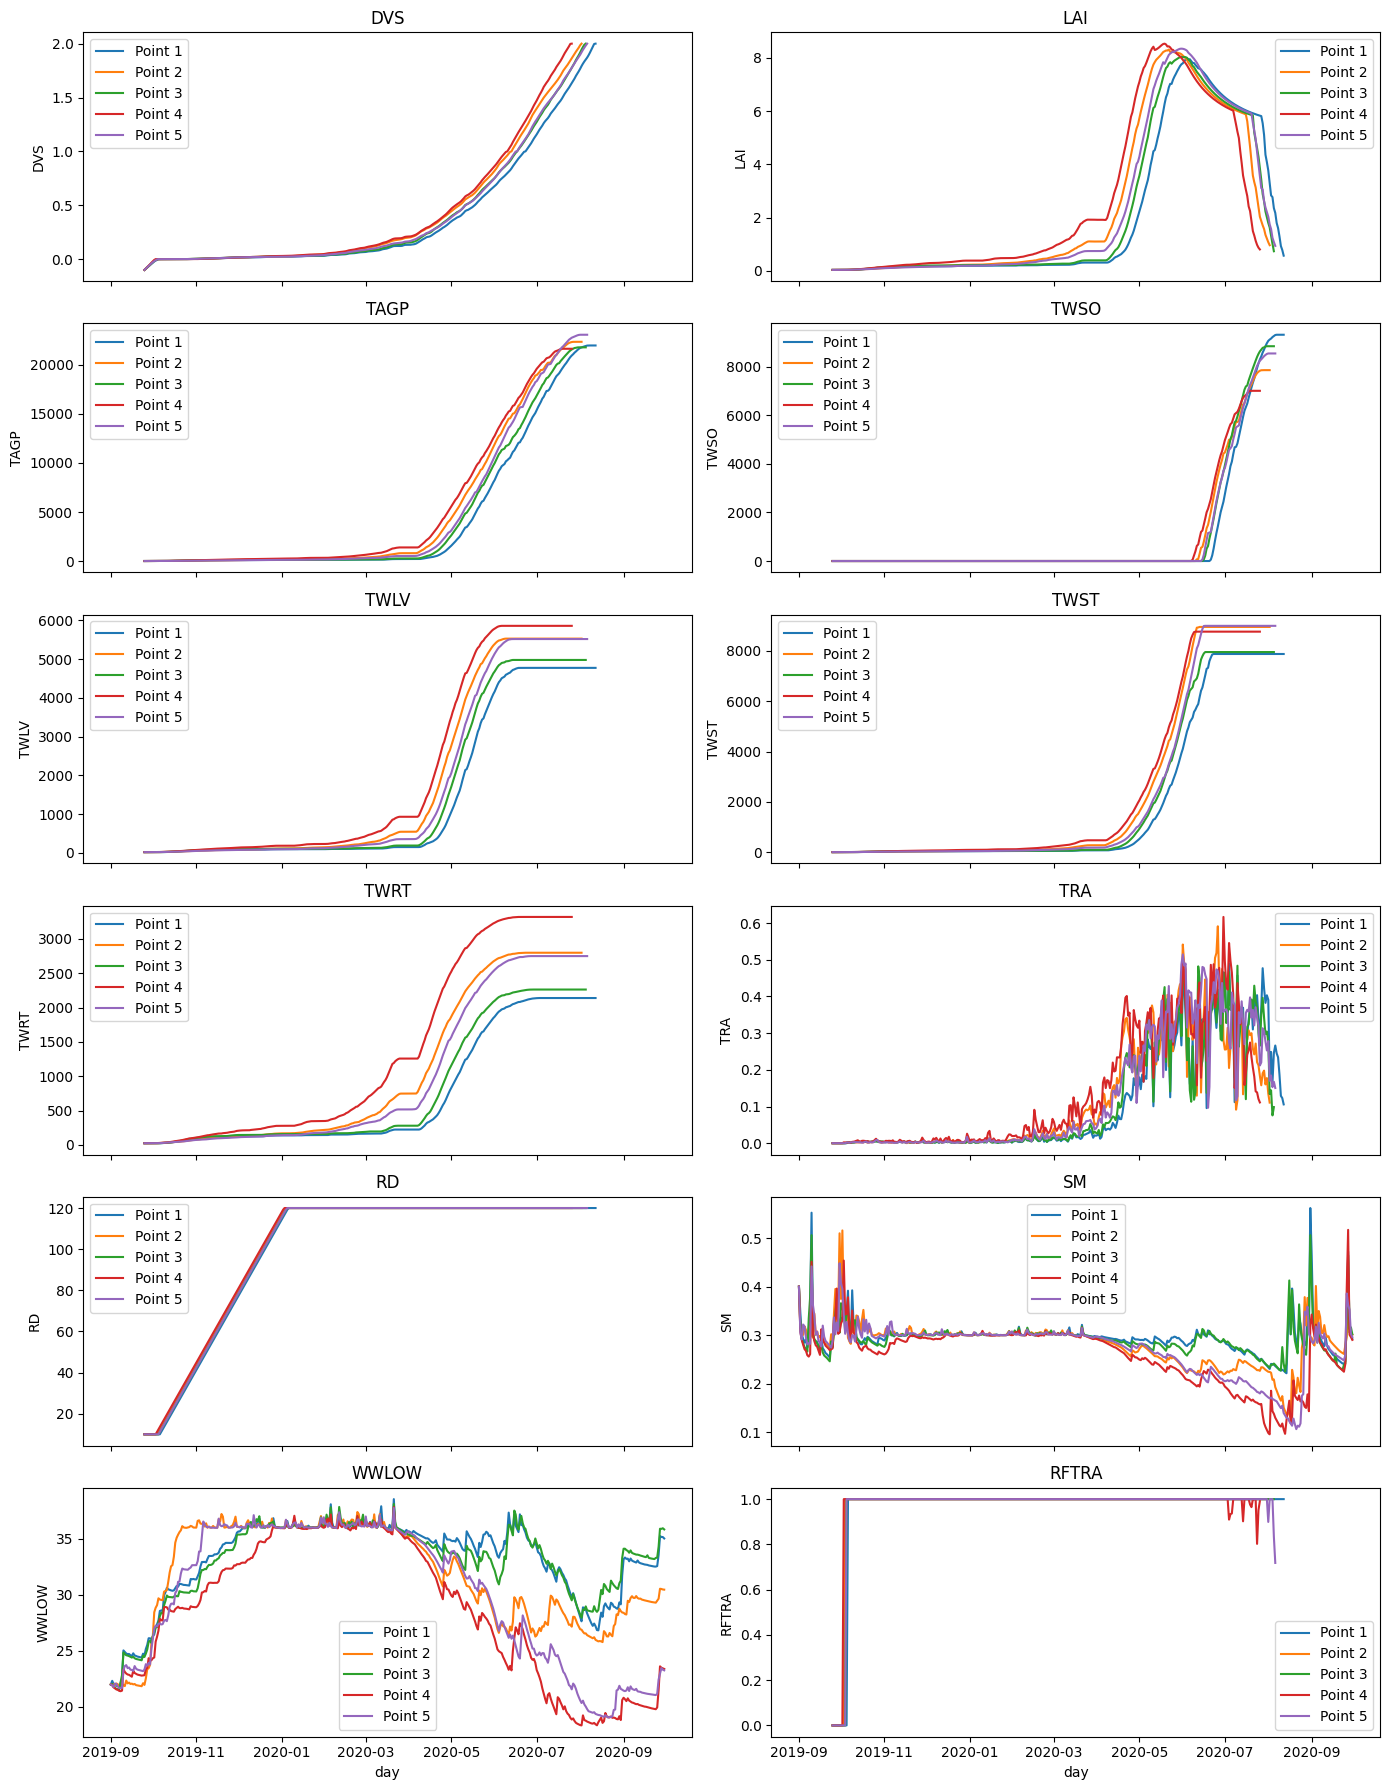

In [8]:
# Ensure 'day' is datetime
batch_results = results.copy()
batch_results["day"] = pd.to_datetime(batch_results["day"])

# Variables to plot (exclude metadata columns)
vars_to_plot = [
    col
    for col in batch_results.columns
    if col not in ["point_id", "latitude", "longitude", "day"]
]

# Layout
cols = 2
rows = math.ceil(len(vars_to_plot) / cols)

# Colors for point_id groups
unique_points = batch_results["point_id"].unique()
palette = sns.color_palette("tab10", len(unique_points))
color_map = {pid: palette[i] for i, pid in enumerate(unique_points)}

fig, axes = plt.subplots(rows, cols, figsize=(14, 3 * rows), sharex=True)
axes = axes.flatten()

for i, var in enumerate(vars_to_plot):
    ax = axes[i]

    for pid in unique_points:
        df_sub = batch_results[batch_results["point_id"] == pid]

        sns.lineplot(
            x=df_sub["day"],
            y=df_sub[var],
            ax=ax,
            label=f"Point {pid}",
            color=color_map[pid],
        )

    ax.set_title(var)
    ax.legend()

# Hide remaining empty subplots
for j in range(len(vars_to_plot), len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()

## Sensitivity analysis using FAST (Fourier Amplitude Sensitivity Test) method

In [9]:
# Instantiate WOFOST Sensitivity Analyzer
sa = WOFOSTSensitivityAnalyzer(batch_runner)

# Define the problem
problem = {
    "num_vars": 3,
    "names": ["TSUM1", "TSUM2", "SPAN"],
    "bounds": [[800, 1200], [900, 1300], [28, 35]],  # TSUM1  # TSUM2  # SPAN
}

sa_result = sa.run_analysis(
    problem,
    method="fast",
    n_samples=512,
    target_variable="TWSO",
    mode="local",
    n_workers=70,
)

[SA] Loading simulation engines...
[BATCH INIT] Pre-loading data for 5 locations...
[SA] Mode: LOCAL | Params: 1536 | Locations: 5
[SA] Total Simulations: 7680


[SA] Simulating: 100%|██████████| 7680/7680 [01:49<00:00, 70.20it/s]


[SA] Analyzing local sensitivity...


## Plot the data

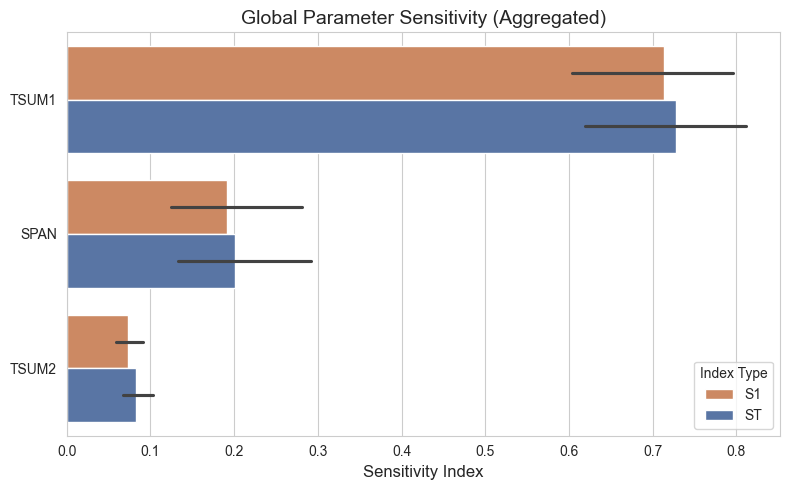

In [10]:
def plot_global(df):
    df_melt = df.melt(
        id_vars="Parameter",
        value_vars=["S1", "ST"],
        var_name="Index",
        value_name="Score",
    )

    plt.figure(figsize=(8, 5))
    sns.set_style("whitegrid")

    sns.barplot(
        data=df_melt,
        x="Score",
        y="Parameter",
        hue="Index",
        palette={"ST": "#4c72b0", "S1": "#dd8452"},
    )

    plt.title("Global Parameter Sensitivity (Aggregated)", fontsize=14)
    plt.xlabel("Sensitivity Index", fontsize=12)
    plt.ylabel("")
    plt.legend(title="Index Type")
    plt.tight_layout()
    plt.show()


plot_global(sa_result)

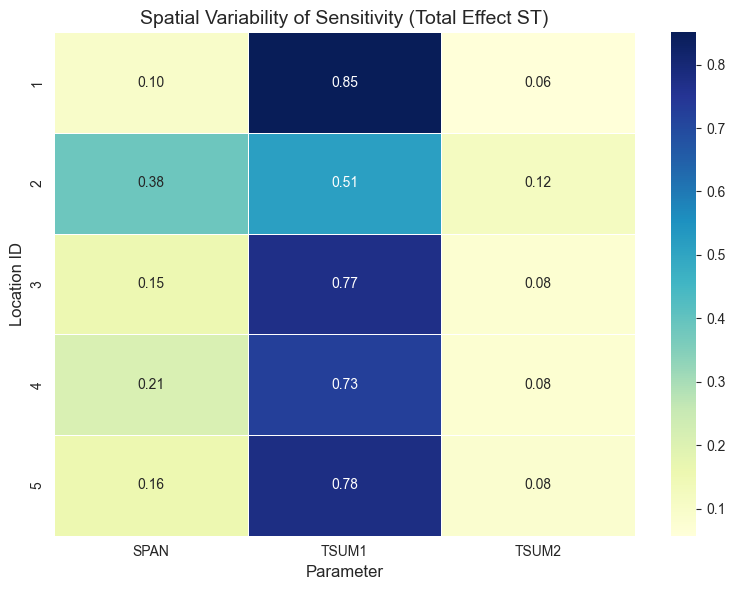

In [11]:
def plot_local_heatmap(df):
    pivot_df = df.pivot(index="point_id", columns="Parameter", values="ST")

    plt.figure(figsize=(8, 6))
    sns.heatmap(pivot_df, annot=True, cmap="YlGnBu", fmt=".2f", linewidths=0.5)

    plt.title("Spatial Variability of Sensitivity (Total Effect ST)", fontsize=14)
    plt.ylabel("Location ID", fontsize=12)
    plt.xlabel("Parameter", fontsize=12)
    plt.tight_layout()
    plt.show()


plot_local_heatmap(sa_result)

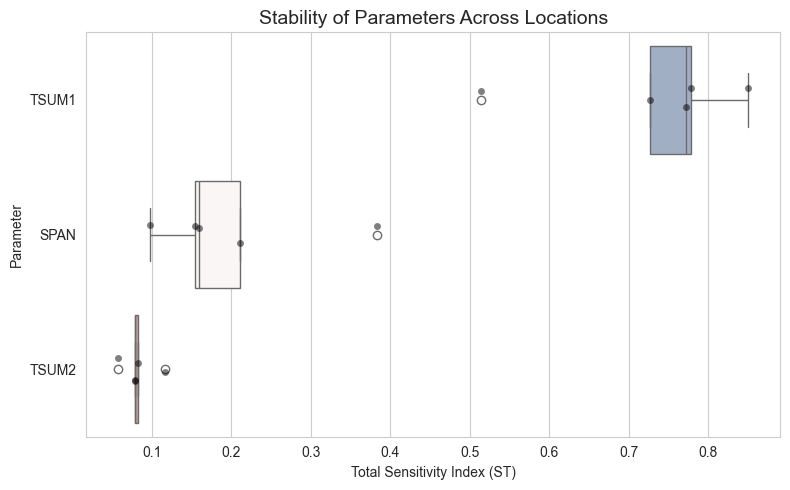

In [12]:
def plot_local_distribution(df):
    plt.figure(figsize=(8, 5))
    sns.boxplot(data=df, x="ST", y="Parameter", hue="Parameter", palette="vlag")
    sns.stripplot(data=df, x="ST", y="Parameter", color="black", alpha=0.5, jitter=True)

    plt.title("Stability of Parameters Across Locations", fontsize=14)
    plt.xlabel("Total Sensitivity Index (ST)")
    plt.tight_layout()
    plt.show()


plot_local_distribution(sa_result)